<a id='top'></a>
# Exploring trends in extreme weather phenomena in Germany
##### by Janik Valentin

### Table of Contents:
- [Introduction](#intro)
- [1. Data Understanding and Data Preparation](#understand)
 - [1.1. Imports and Loading](#import)
 - [1.2. Data Exploration](#explore)
 - [1.3. External Data Verification](#verify)
- [2. Modeling and Evaluation](#model)
 - [2.1. Heavy rainfall events by year](#year)
 - [2.2. Annual heavy rainfall events by severity](#severe)
 - [2.3. Heavy rainfall events by month](#month)
 - [2.4. Heavy rainfall events by state](#state)
 - [2.5. Heavy rainfall events by weather station](#station)
 - [2.6. What about droughts?](#drought)
- [Concluding Words](#conclusion)

<a id='intro'></a>
## Introduction

<div style="text-align: justify">
On July 14th 2021, the amount of precipitation exceeded 100 liters per m2 in one day in parts of North Rhine-Westphalia and Rhineland-Palatinate. The consequences were more than 100 people losing their lives to the floods and billions of euros in material damage. Talking about it with a friend, he shared his impression that there is an increase in extreme weather phenomena in recent years. I didn’t know whether to agree or disagree. Climate change induced rising temperatures is a generally recognized observation, but little have I heard of heavy rainfall events. So I went on the hunt for answers. 
    </div>

Specifically, I was interested in the following:
-	Are heavy rainfall events becoming more frequent in Germany?
-	What about seasonality of these events?
-	Which state/region is most prone to experience heavy rainfalls?
-   And what about droughts?

<br />

<div style="text-align: justify">
In Germany, the German Meteorological Service is responsible for collecting and archiving meteorological data. Most of the data is made publicly available and can be accessed [here]( https://cdc.dwd.de/portal/). Since they publish data for each weather station individually, I coded a small Python script (scraper.ipynb) which queries the website and scrapes the historic data for each weather station. This notebook is about analysing the data obtained from the German Meteorological Service. 
    </div>

<a id='understand'></a>
## 1. Data Understanding and Data Preparation

<a id='imports'></a>
### 1.1. Imports and Loading

In [1]:
# file handling
import os
import glob

# date handling
from datetime import datetime
from datetime import date

# data manipulation
import numpy as np
import pandas as pd

# plots
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

# geoplots
import geopandas as gpd
from shapely.geometry import Point

In [2]:
# get path for each txt file
path = os.getcwd() + '\\data\\'
files = glob.glob(os.path.join(path, '*.txt'))

In [3]:
%%time

# you don't have to run this cell.
# It was only needed once to write all data from the multiple files into one large csv file. 

# read each txt file and write content to one df containing all data
df = pd.DataFrame()

for file in files: 
    # read file
    sub_df = pd.read_csv(file, sep=';')
    
    # change date column from int to datetime format
    sub_df.MESS_DATUM = pd.to_datetime(sub_df.MESS_DATUM, format='%Y%m%d')
    
    # remove whitespaces from column headers
    sub_df.columns = sub_df.columns.str.strip()
    
    # limit df to relevant columns
    sub_df = sub_df[['STATIONS_ID', 'MESS_DATUM', 'RSK']]
    
    # write content to main df
    df = df.append(sub_df)

Wall time: 4min 9s


In [4]:
# save df as csv
df.to_csv('data/weather_data.csv', index=False, compression='zip')

In [5]:
# load df
df = pd.read_csv('data/weather_data.csv', parse_dates=['MESS_DATUM'], compression='zip')

<a id='explore'></a>
### 1.2. Data exploration

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16572546 entries, 0 to 16572545
Data columns (total 3 columns):
 #   Column       Dtype         
---  ------       -----         
 0   STATIONS_ID  int64         
 1   MESS_DATUM   datetime64[ns]
 2   RSK          float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 379.3 MB


In [7]:
df

,STATIONS_ID,MESS_DATUM,RSK
0,2290,1781-01-01,0.0
1,2290,1781-01-02,0.0
2,2290,1781-01-03,0.0
3,2290,1781-01-04,4.6
4,2290,1781-01-05,2.9
...,...,...,...
16572541,15801,2020-12-27,-999.0
16572542,15801,2020-12-28,-999.0
16572543,15801,2020-12-29,-999.0
16572544,15801,2020-12-30,-999.0


The dataset contains 16,725,546 rows across 3 columns. The columns include a uniqe ID for each station, the date of the recording and the amount of precipitation (RSK). The full documentation regarding the measurement methods and estimation of data quality can be found on the website of the German Meteorological Service [here](https://opendata.dwd.de/climate_environment/CDC/observations_germany/climate/daily/kl/historical/DESCRIPTION_obsgermany_climate_daily_kl_historical_en.pdf). 

In [8]:
# check for duplicates
df.duplicated().any()

False

In [9]:
# create copy of df to perform cleaning
df_clean = df.copy()

In [10]:
# add year column to assist in future analyses
df_clean['YEAR'] = df_clean.MESS_DATUM.dt.year

# add month column to assist in future analyses
df_clean['MONTH'] = df_clean.MESS_DATUM.dt.month

<div style="text-align: justify">
If a weather station did not deliver any data for a given day, the value is set to -999. This distorts the dataset in any future investigation. Since there is no meaningful way for me to fill these values with an approximation, I decided to remove the missing values all together. 
    </div>

In [11]:
# remove missing values
df_clean = df_clean[df_clean['RSK']!=-999]

Limit data to time interval interested

In [12]:
# filter by date
df_clean = df_clean[(df_clean['MESS_DATUM']>='1900-01-01') & (df_clean['MESS_DATUM']<='2020-12-31')]

Get info about used weather stations

In [13]:
# count of unique weather stations
df_clean.STATIONS_ID.nunique()

1084

Data is obtained from 1084 unique weather stations in Germany.

#### Amount of data per year

In [14]:
# group df by year and count days where RSK is recorded
df_count = df_clean.groupby('YEAR')['RSK'].count().reset_index()

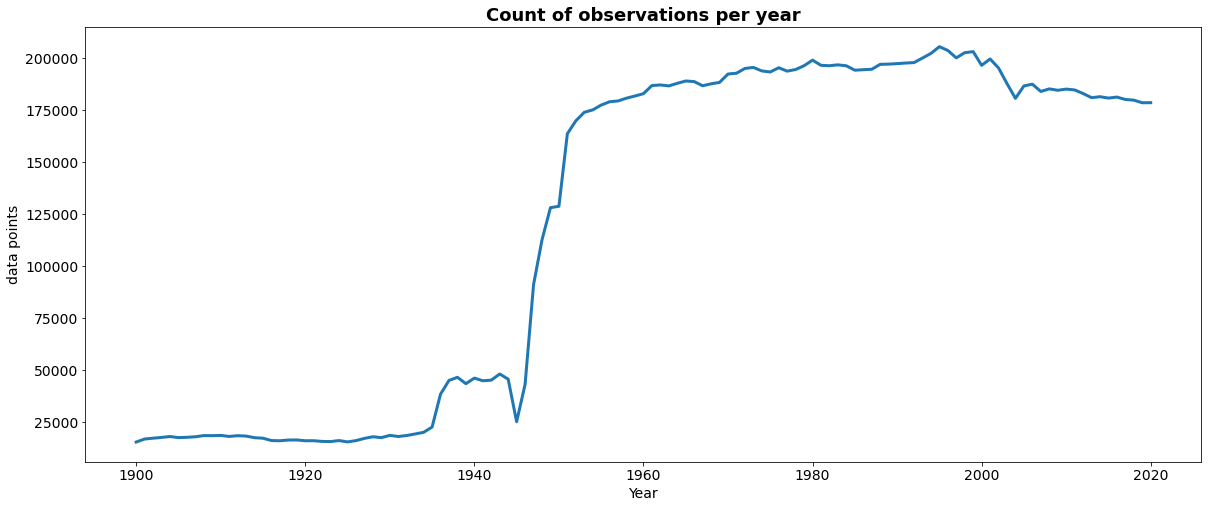

In [15]:
# plot
plt.figure(figsize=(20, 8))
sns.lineplot(data=df_count, x='YEAR', y='RSK', linewidth=3)
plt.title('Count of observations per year', fontsize=18, fontweight='bold')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Year', fontsize=14)
plt.ylabel('data points', fontsize=14)
plt.savefig('plots/count.jpg', bbox_inches='tight');

<div style="text-align: justify">
In the years following the end of WWII, there was a visible boom in meteorological observations. This discrepancy in observations is important to note and means that I’ll have to adjust the count of extreme weather phenomena by the amount of observations.
    </div>

#### Location of weather stations

In [16]:
# read txt file containing info about each weather station
df_stations = pd.read_csv('geodata/data_cleaned.txt', header=None, delimiter=r'\s+', encoding='latin-1')

# rename column headers
column_headers = {0: 'STATIONS_ID', 
                  4: 'LATITUDE', 
                  5: 'LONGITUDE', 
                  6: 'LOCATION', 
                  7: 'STATE'}
# rename
df_stations.rename(columns=column_headers, inplace=True)

# filter on relevant columns
df_stations = df_stations[['STATIONS_ID', 'LATITUDE', 'LONGITUDE', 'LOCATION', 'STATE']]

In [17]:
# grid of germany
geo_de = gpd.read_file('geodata/shapefiles/DEU_adm1.shp')
geo_de = geo_de[['NAME_1', 'geometry']]

# datapoints for weather stations
geometry = [Point(xy) for xy in zip(df_stations['LONGITUDE'], df_stations['LATITUDE'])]
geo_df = gpd.GeoDataFrame(df_stations, geometry=geometry)

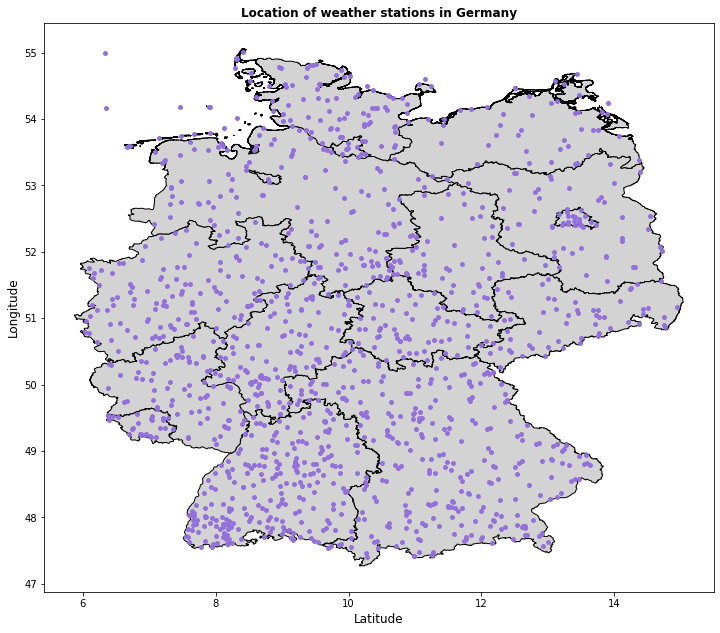

In [18]:
fig, ax = plt.subplots(figsize=(12, 12))
geo_de.plot(ax = ax, color='lightgrey', edgecolor='black')
geo_df.plot(ax = ax, markersize=15, color='mediumpurple')
plt.title('Location of weather stations in Germany', fontsize=12, fontweight='bold')
plt.xlabel('Latitude', fontsize=12)
plt.ylabel('Longitude', fontsize=12)
plt.savefig('plots/location_of_weather_stations.jpg', bbox_inches='tight');

<div style="text-align: justify">
The 1084 weather stations are distributed across whole Germany. This ensures, that each state is sufficiently represented and regional bias is minimized. Nevertheless, there are more weather stations in the south-west of Germany than there are in the east of Germany. 
    </div>

<a id='verify'></a>
### External data verification

When working with a dataset, it is always good practice to verify the credibility of your data. One way you could do this is to externally verify the dataset with a known event. For this project, let's take a look at the Elbe and Donau flood in August 2002. If the dataset is accurate, it should show high amounts of precipitation in the south and east of Germany on August 11, 2002 that caused the Elbe and Donau to step over their shores.    

In [19]:
# filter on date
df_20020811 = df_clean[df_clean['MESS_DATUM']=='2002-08-11']

# merge with location data for weather stations
df_20020811_merged = df_20020811.merge(geo_df, on='STATIONS_ID')

# convert to GeoDataFrame for plot
df_20020811_merged = gpd.GeoDataFrame(df_20020811_merged)

In [20]:
def plot_geodataframe(shapefile, data, column, title, ylabel, save_path):
    '''
    plots a map with data points on it and saves plot.
    
    Parameters: 
    shapefile (df): containing shapefile information about the map
    data (df): dataframe with data
    column (str): column name of df that contains data for plotting
    title (str): containing title of plot
    ylabel (str): containing y axis label of plot
    save_path (str): of path were plot should be saved
    
    Returns:
    plot (matplotlib plot)
    '''
    fig, ax = plt.subplots(figsize=(12, 12))

    # germany grid
    shapefile.plot(ax = ax, color='lightgrey', edgecolor='black')
    plt.title(title, fontsize=12, fontweight='bold')
    plt.xlabel('Latitude', fontsize=12)
    plt.ylabel('Longitude', fontsize=12)

    # color map
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    data.plot(ax = ax, column=column, markersize=35, cmap='Blues', legend=True, cax=cax)
    plt.ylabel(ylabel, fontsize=12)
    
    # save figure
    plt.savefig(save_path, bbox_inches='tight');

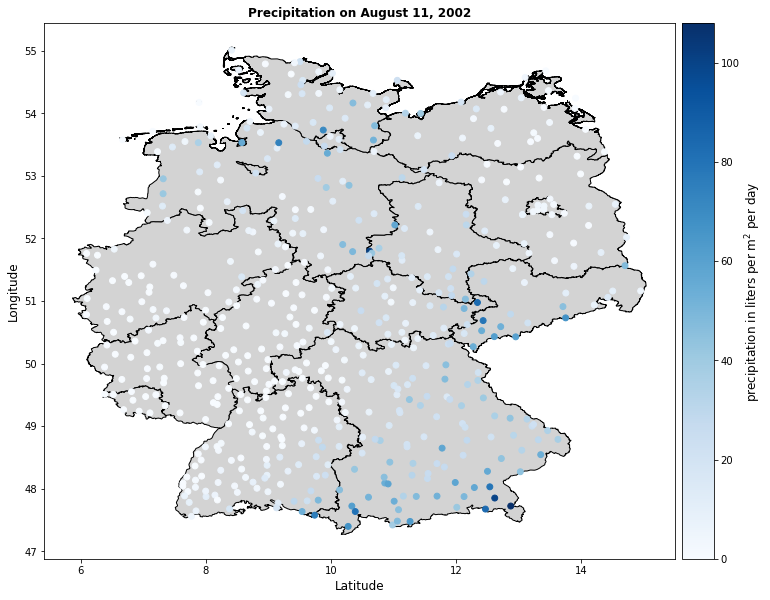

In [21]:
plot_geodataframe(shapefile = geo_de, 
                  data = df_20020811_merged,
                  column = 'RSK',
                  title = 'Precipitation on August 11, 2002',
                  ylabel = 'precipitation in liters per m$^2$ per day', 
                  save_path = 'plots/verify.jpg')

Clearly visible are numerous weather stations reporting high precipitation figures. The dataset dimensions time, location and amount of precipitation can therefore be regarded as credible.

<a id='model'></a>
## 2. Modeling and Evaluation

<a id='year'></a>
### 2.1. Heavy rainfall events by year

The German Meteorological Service generraly speaks of heavy rainfall if the amount of precipitaion exceeds 25 liters per m$^2$ in 1 hour or 35 liters per m$^2$ within 6 hours [[1]](https://at.wetter.com/wetterlexikon/starkregen_aid_570f4f32cebfc0060e8b46ef.html). Since the dataset I gathered is aggregated over the daily amount precipitation, I will use the threshold of 35 liters per m$^2$ per day to classify a heavy rainfall event.

Here’s the chart for the yearly aggregated amount of heavy rainfall events – adjusted by the amount of observations for the respective year.  

In [22]:
# filter on heavy rainfall events
df_heavy_rainfall = df_clean[df_clean['RSK']>=35]

In [23]:
# group by year
df_RSK = df_heavy_rainfall.groupby('YEAR')['RSK'].count().reset_index()

# merge number of observations per year
df_RSK = df_RSK.merge(df_count, on='YEAR', suffixes=(None, '_COUNT'))

# calculate adjusted RSK
df_RSK['RSK_RELATIVE'] = df_RSK.RSK / df_RSK.RSK_COUNT

# 25 year moving average
df_RSK['25_YEAR_MA_RSK'] = df_RSK['RSK_RELATIVE'].rolling(25, 25).mean()

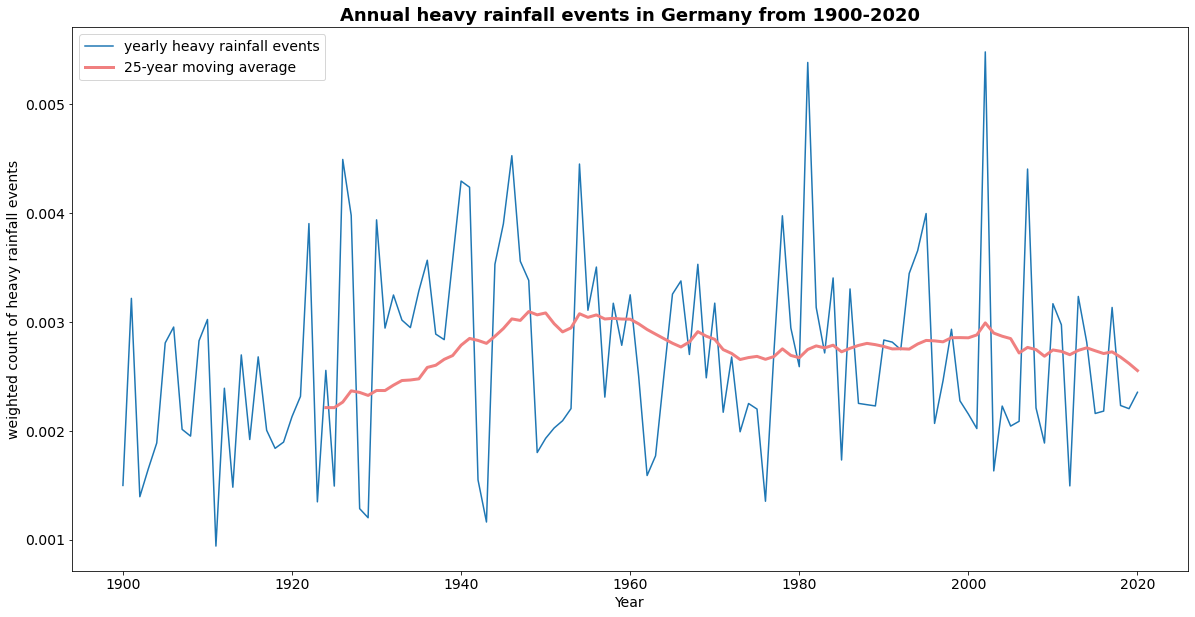

In [24]:
plt.figure(figsize=(20, 10))

sns.lineplot(data=df_RSK, x='YEAR', y='RSK_RELATIVE', label='yearly heavy rainfall events')
sns.lineplot(data=df_RSK, x='YEAR', y='25_YEAR_MA_RSK', linewidth=3, label='25-year moving average', color='lightcoral')

plt.title('Annual heavy rainfall events in Germany from 1900-2020', fontsize=18, fontweight='bold')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel('weighted count of heavy rainfall events', fontsize=14)
plt.xlabel('Year', fontsize=14)
plt.legend(fontsize=14)
plt.savefig('plots/hr_by_year.jpg', bbox_inches='tight');

<a id='severe'></a>
### 2.2. Annual heavy rainfall events by severity

In [25]:
# group by year and calculate mean precipitation of heavy rainfall events
df_severe = df_heavy_rainfall.groupby('YEAR')['RSK'].mean().reset_index()

# 25-year MA
df_severe['25_YEAR_MA_RSK'] = df_severe['RSK'].rolling(25, 25).mean()

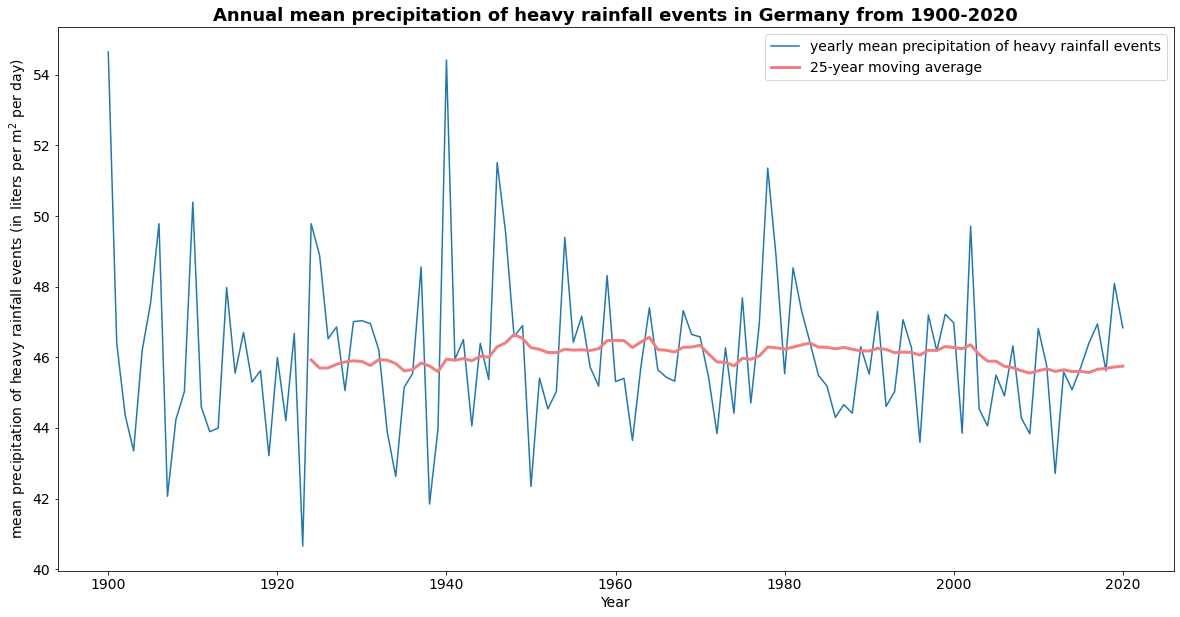

In [26]:
plt.figure(figsize=(20, 10))

sns.lineplot(data=df_severe, x='YEAR', y='RSK', label='yearly mean precipitation of heavy rainfall events')
sns.lineplot(data=df_severe, x='YEAR', y='25_YEAR_MA_RSK', linewidth=3, label='25-year moving average', color='lightcoral')

plt.title('Annual mean precipitation of heavy rainfall events in Germany from 1900-2020', fontsize=18, fontweight='bold')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel('mean precipitation of heavy rainfall events (in liters per m$^2$ per day)', fontsize=14)
plt.xlabel('Year', fontsize=14)
plt.legend(fontsize=14)
plt.savefig('plots/hr_severe_by_year.jpg', bbox_inches='tight');

The graph provides no statistical evidence for an increase in severety of heavy rainfall events. Precipitation of heavy rainfall events has remained constant over the observed time period at an average of 46 liters per m$^2$ per event. 

<a id='month'></a>
### 2.3. Heavy rainfall events by month

In [27]:
# group by month and count heavy rainfall events
df_month = df_heavy_rainfall.groupby('MONTH')['RSK'].count().reset_index()

In [28]:
# map numeric month to real name
months = {1: 'January', 2: 'February', 3: 'March', 4: 'April', 5: 'May', 6: 'June', 7: 'July',
          8: 'August', 9: 'September', 10: 'October', 11: 'November', 12: 'December'}

# rename
df_month['MONTH'] = df_month['MONTH'].map(months)

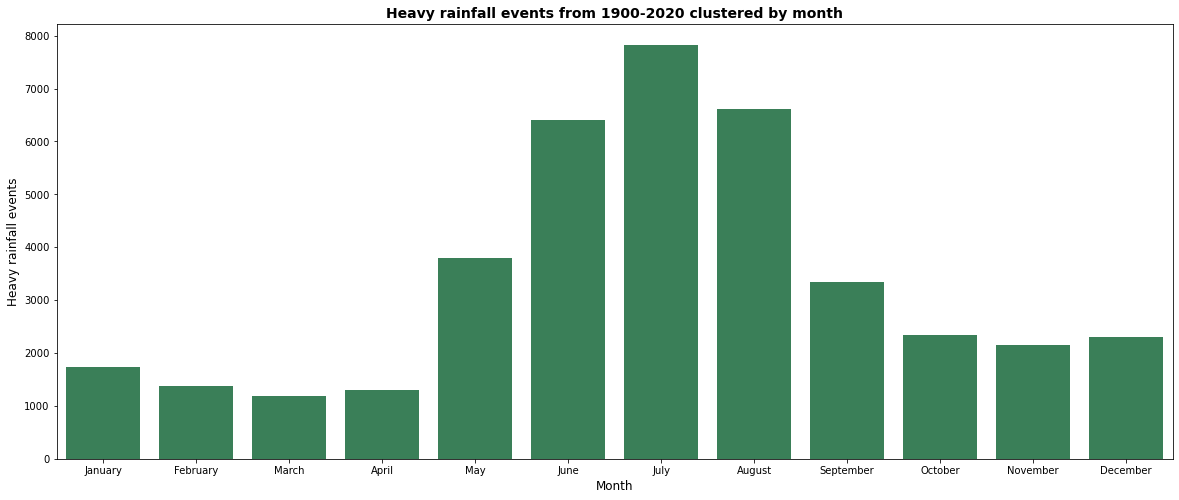

In [29]:
plt.figure(figsize=(20, 8))

sns.barplot(data=df_month, x='MONTH', y='RSK', color='seagreen')

plt.title('Heavy rainfall events from 1900-2020 clustered by month', fontsize=14, fontweight='bold')
plt.xlabel('Month', fontsize=12)
plt.ylabel('Heavy rainfall events', fontsize=12);

Heavy rainfall events are most likely to occur in Germany in the in the summer months from June-August. 

<a id='state'></a>
### 2.4. Heavy rainfall events by state

In [30]:
# drop geometry column from df_stations
df_stations = df_stations.drop('geometry', axis=1)

# merge germany grid data with weather station data
df_geo_merge = geo_de.merge(df_stations, left_on='NAME_1', right_on='STATE')

# merge previous merge with precipitation dataframe
df_geo_merge = df_geo_merge.merge(df_clean, on='STATIONS_ID')

In [31]:
# filter on heavy rainfall events
df_geo_rainfall = df_geo_merge[df_geo_merge['RSK']>=35]

# group by state
df_geo_group = df_geo_rainfall.groupby('STATE').agg({'geometry': 'first', 
                                                     'RSK': 'count'})

In [32]:
# adjust for number of weather stations in each state
# group by state and count observed days
df_geo_days_covered = df_geo_merge.groupby('STATE')['RSK'].count().reset_index()
df_geo_days_covered.rename(columns={'RSK': 'RSK_COUNT'}, inplace=True)

# merge stations count to df
df_geo_group = df_geo_group.merge(df_geo_days_covered, on='STATE')

# calculate adjusted heavy rainfall event count
df_geo_group['ADJUSTED_RSK'] = df_geo_group['RSK'] / df_geo_group['RSK_COUNT']

# convert to geoDF again
df_geo_group = gpd.GeoDataFrame(df_geo_group)

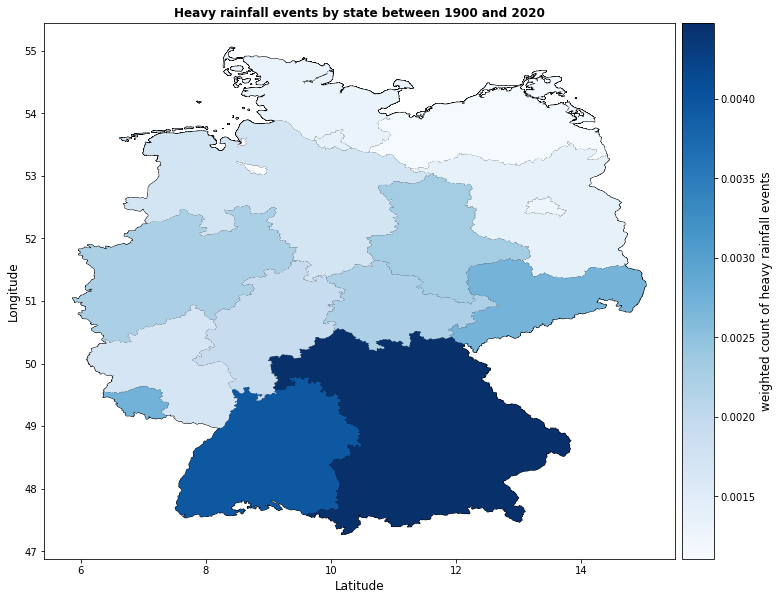

In [33]:
plot_geodataframe(shapefile = geo_de, 
                  data = df_geo_group,
                  column = 'ADJUSTED_RSK',
                  title = 'Heavy rainfall events by state between 1900 and 2020',
                  ylabel = 'weighted count of heavy rainfall events', 
                  save_path = 'plots/hr_by_state.jpg')

<div style="text-align: justify">
Heavy rainfall events are most likely to occur in the states of Bavaria and Baden-Wuerttemberg. Note that the graphic shows the amount of heavy rainfall events relative to the amount of weather stations in each state. The result is therefore independent of the amount of surface area and weather stations in each state. 
    </div>

<a id='station'></a>
### 2.5. Heavy rainfall events by weather station

In [34]:
df_geo_rainfall_station = df_geo_rainfall.copy()

# change geometry from polygon to point
df_geo_rainfall_station.drop('geometry', axis=1, inplace=True)
geometry = [Point(xy) for xy in zip(df_geo_rainfall_station['LONGITUDE'], df_geo_rainfall_station['LATITUDE'])]
df_geo_rainfall_station = gpd.GeoDataFrame(df_geo_rainfall_station, geometry=geometry)

In [35]:
# group by weather station and count heavy rainfall events (keep geometry data for each weather station)
df_geo_rainfall_station_group = df_geo_rainfall_station.groupby('STATIONS_ID').agg({'geometry': 'first', 
                                                                                    'RSK': 'count'})

# merge weather station data with geometry data ()
df_geo_station_days = df_geo_merge.groupby('STATIONS_ID')['RSK'].count().reset_index()
df_geo_station_days.rename(columns={'RSK': 'RSK_COUNT'}, inplace=True)

# merge stations combined weather station data with aggregation of heavy rainfall events per station
df_geo_rainfall_station_group = df_geo_rainfall_station_group.merge(df_geo_station_days, on='STATIONS_ID')

# adjust heavy rainfall events by the amount of days covered by the respective station
df_geo_rainfall_station_group['ADJUSTED_RSK'] = df_geo_rainfall_station_group['RSK'] / df_geo_rainfall_station_group['RSK_COUNT']

# convert to geodf for plot
df_geo_rainfall_station_group = gpd.GeoDataFrame(df_geo_rainfall_station_group)

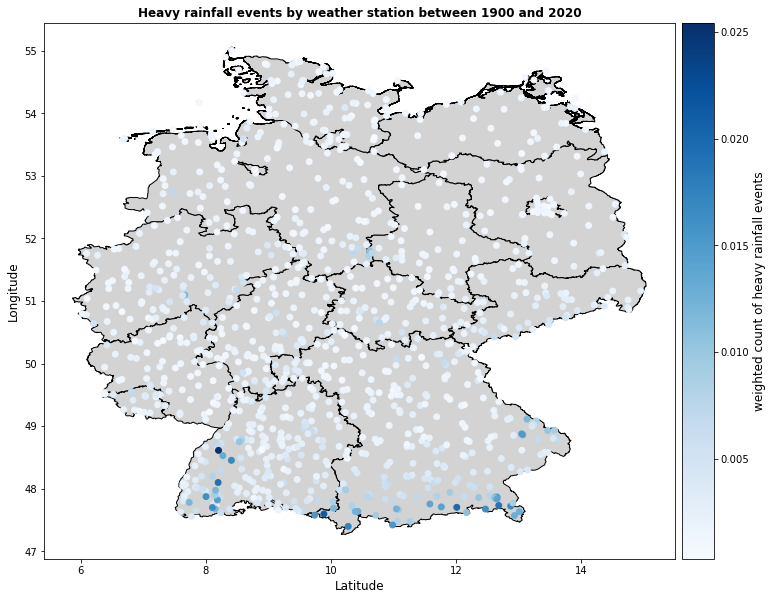

In [36]:
plot_geodataframe(shapefile = geo_de, 
                  data = df_geo_rainfall_station_group,
                  column = 'ADJUSTED_RSK',
                  title = 'Heavy rainfall events by weather station between 1900 and 2020',
                  ylabel = 'weighted count of heavy rainfall events', 
                  save_path = 'plots/hr_by_station.jpg')

<div style="text-align: justify">
The highest probability to experience a heavy rainfall events are at the southern and western border of Bavaria, western parts of Baden-Wuerttemberg and at the southern border of Lower Saxony. One likely explanation for this observation is the proximity of these weather stations to mountain ranges - the Alps at the southern border of Bavaria, the Bavarian Forest in the east of Bavaria, the Harz Mountains in Lower Saxony and the Black Forest in Badem-Wuerttemberg. Nevertheless, a statistical proof of this observation is not possible with the dataset at hand and remains an open task for future investigations. Otherwise, there appear to be only minor differences across Germany.
    </div>

<a id='drought'></a>
### 2.6. Drought events

The German Meteorological Service defines a period of time as a drought, if the amount of precipitation is less than 1 liter per m$^2$ over a period of 11 consecutive days [[2]](https://www.climate-service-center.de/products_and_publications/publications/detail/063194/index.php.de). 

In [37]:
# create df for drought analysis
df_drought = df_clean.copy()

# window over 11 subsequent days - calculate sum of precipitation of last 11 days
df_drought['10_DAY_DROUGHT'] = df_drought.groupby('STATIONS_ID')['RSK'].transform(lambda x: x.rolling(11, 11).sum())

# filter on drought event
df_drought = df_drought[df_drought['10_DAY_DROUGHT']<=1]

# group by year
df_drought_year = df_drought.groupby('YEAR')['10_DAY_DROUGHT'].count().reset_index()

# merge number of observations per year
df_drought_year = df_drought_year.merge(df_count, on='YEAR')

# calculate adjusted RSK
df_drought_year['10_DAY_DROUGHT_RELATIVE'] = df_drought_year['10_DAY_DROUGHT'] / df_drought_year.RSK
df_drought_year['25_YEAR_MA_DROUGHT'] = df_drought_year['10_DAY_DROUGHT_RELATIVE'].rolling(25, 25).mean()

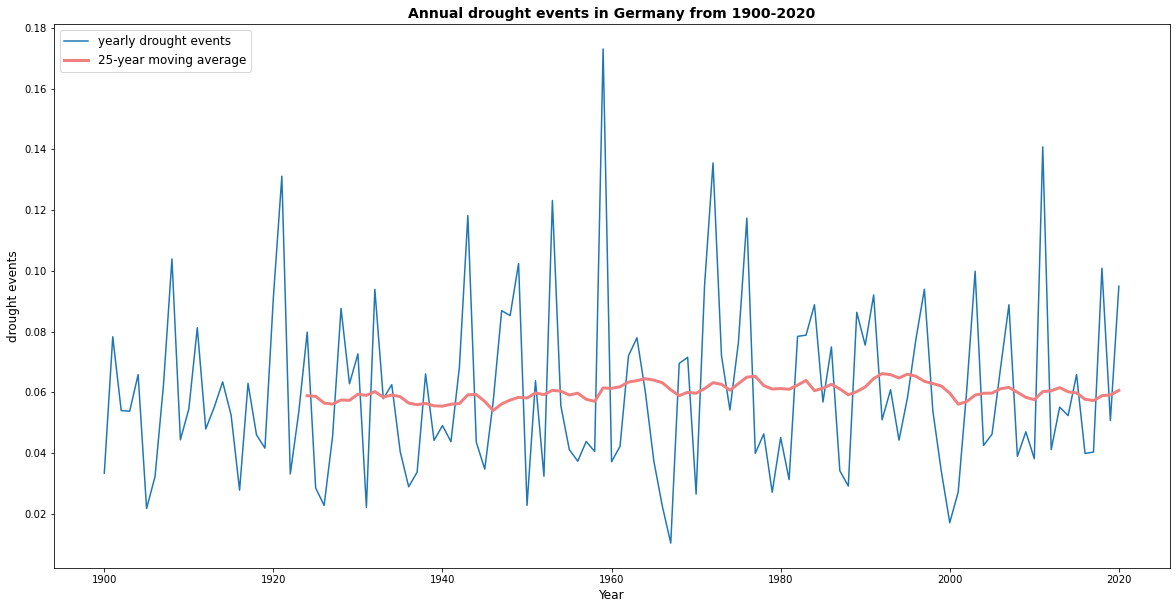

In [38]:
plt.figure(figsize=(20, 10))

sns.lineplot(data=df_drought_year, x='YEAR', y='10_DAY_DROUGHT_RELATIVE', label='yearly drought events')
sns.lineplot(data=df_drought_year, x='YEAR', y='25_YEAR_MA_DROUGHT', linewidth=3,
             label='25-year moving average', color='lightcoral')

plt.title('Annual drought events in Germany from 1900-2020', fontsize=14, fontweight='bold')
plt.ylabel('drought events', fontsize=12)
plt.xlabel('Year', fontsize=12)
plt.legend(fontsize=12, loc='upper left');

Similar to the observation of heavy rainfall events, the amount of droughts per year is subject to a high yearly variance. But the 25-year moving average line shows no significant increase or decrease in events over the last century.  

<a id='conclusion'></a>
## Concluding Words

<div style="text-align: justify">
This analysis investigated heavy rainfall and drought events in Germany over the last 120 years. Regarding the yearly amount of heavy rainfall events, no significant increase or decrease was found. The same applies for the yearly amount of droughts. The summer months from June to August were shown to be responsible for the highest amount of heavy rainfall events. The analysis of regional differences revealed Bavaria and Baden-Wuerttemberg as the states most often affected by heavy rainfall events. Weather stations with close proximity to Germanys highest mountain ranges showed higher than average counts for heavy rainfall events. All statistics have been calculated to best knowledge and belief, but without warranty for correctness. 
    </div>

[go to top](#top)